<a href="https://www.kaggle.com/sdysch/nlp-disaster-tweets?scriptVersionId=88263823" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [2]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test  = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
print(df_train.columns)
print(df_test.columns)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Index(['id', 'keyword', 'location', 'text'], dtype='object')


In [3]:
print(df_train.head())
print(len(df_train))
print(df_test.head())
print(len(df_test))

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
7613
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
3263


In [4]:
# preprocessing, lower case
df_train['text'] = df_train['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()


In [5]:
# remove URLS
import re

def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    
    return url.sub(r'', text)

df_train['text'] = df_train['text'].apply(remove_urls)
df_test['text']  = df_test['text'].apply(remove_urls)

In [6]:
X_train = df_train['text']
y_train = df_train['target']

X_test = df_test['text']

print(X_train.head(20))

0     our deeds are the reason of this #earthquake m...
1                forest fire near la ronge sask. canada
2     all residents asked to 'shelter in place' are ...
3     13,000 people receive #wildfires evacuation or...
4     just got sent this photo from ruby #alaska as ...
5     #rockyfire update => california hwy. 20 closed...
6     #flood #disaster heavy rain causes flash flood...
7     i'm on top of the hill and i can see a fire in...
8     there's an emergency evacuation happening now ...
9     i'm afraid that the tornado is coming to our a...
10          three people died from the heat wave so far
11    haha south tampa is getting flooded hah- wait ...
12    #raining #flooding #florida #tampabay #tampa 1...
13              #flood in bago myanmar #we arrived bago
14    damage to school bus on 80 in multi car crash ...
15                                       what's up man?
16                                        i love fruits
17                                     summer is

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 40
n_words = 100000
tokenizer = Tokenizer(oov_token='<OOV>', num_words=n_words)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, padding='post', maxlen=max_length)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded    = pad_sequences(testing_sequences, padding='post', maxlen=max_length)
print(training_padded.shape)
print(testing_padded.shape)

(7613, 40)
(3263, 40)


In [8]:
print(training_padded.max())

18098


In [9]:
"""# scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
training_padded_scaled = scaler.fit_transform(training_padded)
testing_padded_scaled  = scaler.transform(testing_padded)

print(training_padded_scaled[3])"""

'# scaling\nfrom sklearn.preprocessing import MinMaxScaler\nscaler = MinMaxScaler()\ntraining_padded_scaled = scaler.fit_transform(training_padded)\ntesting_padded_scaled  = scaler.transform(testing_padded)\n\nprint(training_padded_scaled[3])'

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, GlobalAveragePooling1D, Dropout
model = Sequential()
model.add(Embedding(n_words, 50, input_length=training_padded.shape[1]))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.25))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 50)            5000000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 30)                1530      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 5,001,561
Trainable params: 5,001,561
Non-trainable params: 0
_________________________________________________________________


2022-02-19 22:42:38.165632: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=20, verbose=1, restore_best_weights=True, mode='auto')
#callbacks = [es]
callbacks = []
    
epochs = 4
batch_size = 32

history = model.fit(training_padded,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks,
          validation_split=0.2,
          shuffle=True)

Epoch 1/4


2022-02-19 22:42:38.386900: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


191/191 [==============================] - 5s 23ms/step - loss: 0.6670 - accuracy: 0.5860 - val_loss: 0.6427 - val_accuracy: 0.5844
Epoch 2/4
191/191 [==============================] - 4s 21ms/step - loss: 0.5097 - accuracy: 0.7808 - val_loss: 0.4941 - val_accuracy: 0.7800
Epoch 3/4
191/191 [==============================] - 4s 21ms/step - loss: 0.3575 - accuracy: 0.8581 - val_loss: 0.4528 - val_accuracy: 0.7965
Epoch 4/4
191/191 [==============================] - 4s 22ms/step - loss: 0.2684 - accuracy: 0.8970 - val_loss: 0.4545 - val_accuracy: 0.7938


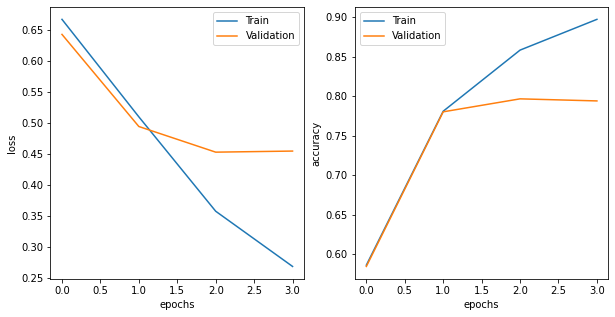

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(history.history['loss'], label='Train')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend(loc='best')

ax[1].plot(history.history['accuracy'], label='Train')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].legend(loc='best')


plt.show()

In [13]:
y_pred = model.predict(testing_padded)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [14]:
sub = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
sub['target'] = y_pred
sub.to_csv('submission.csv', index=False)